## Extract LDM Latents

In this notebook, we show how to extract unet latents 

Motivated by [Sparse AutoEncoder](https://github.com/openai/sparse_autoencoder) and [Transformer Lens](https://github.com/TransformerLensOrg/TransformerLens)

The outputs are obtained on a TPU v4-8.

In [1]:
# Import Modules
"""
 Copyright 2024 Google LLC

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      https://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
 """

import functools
import os
import time
from typing import Sequence
import sys
sys.path.append("src") # run maxdiffusion codebase in editable mode

import numpy as np

import jax
import jax.numpy as jnp
from maxdiffusion.max_utils import (
  create_device_mesh,
  get_dtype,
  get_states,
  device_put_replicated,
  get_flash_block_sizes
)
from maxdiffusion import pyconfig
from absl import app
from maxdiffusion import (
  FlaxStableDiffusionPipeline,
  FlaxDDIMScheduler,
  FlaxUNet2DConditionModel
)

from maxdiffusion.maxdiffusion_utils import rescale_noise_cfg
from flax.linen import partitioning as nn_partitioning
from jax.experimental.compilation_cache import compilation_cache as cc
from jax.sharding import Mesh, PositionalSharding
from maxdiffusion.image_processor import VaeImageProcessor

cc.set_cache_dir(os.path.expanduser("~/jax_cache"))


2024-07-11 14:52:13.480397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 14:52:13.480457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 14:52:13.481596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 14:52:14.467373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
# Define Functions (capture intermediates in loop_body)
def loop_body(step, args, model, pipeline, prompt_embeds, guidance_scale, guidance_rescale):
    latents, scheduler_state, state, intermediates = args
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = pipeline.scheduler.scale_model_input(scheduler_state, latents_input, t)

    model_out, intermediates = model.apply(
        {"params" : state.params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=prompt_embeds,
        capture_intermediates=True
    )
    noise_pred = model_out.sample

    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
    noise_pred = rescale_noise_cfg(noise_pred, noise_prediction_text, guidance_rescale=guidance_rescale)

    latents, scheduler_state = pipeline.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()

    return latents, scheduler_state, state, intermediates

def tokenize(prompt, tokenizer):
    """Tokenizes prompt."""
    return tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="np"
    ).input_ids

def get_unet_inputs(rng, config, batch_size, pipeline, params):
    vae_scale_factor = 2 ** (len(pipeline.vae.config.block_out_channels) - 1)
    prompt_ids = [config.prompt] * batch_size
    prompt_ids = tokenize(prompt_ids, pipeline.tokenizer)
    negative_prompt_ids = [config.negative_prompt] * batch_size
    negative_prompt_ids = tokenize(negative_prompt_ids, pipeline.tokenizer)
    guidance_scale = config.guidance_scale
    guidance_rescale = config.guidance_rescale
    num_inference_steps = config.num_inference_steps

    prompt_embeds = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
    negative_prompt_embeds = pipeline.text_encoder(negative_prompt_ids, params=params["text_encoder"])[0]
    context = jnp.concatenate([negative_prompt_embeds, prompt_embeds])
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    guidance_rescale = jnp.array([guidance_rescale], dtype=jnp.float32)

    batch_size = prompt_ids.shape[0]
    latents_shape = (
        batch_size,
        pipeline.unet.config.in_channels,
        config.resolution // vae_scale_factor,
        config.resolution // vae_scale_factor,
    )
    latents = jax.random.normal(rng, shape=latents_shape, dtype=jnp.float32)

    scheduler_state = pipeline.scheduler.set_timesteps(
        params["scheduler"],
        num_inference_steps=num_inference_steps,
        shape=latents.shape
    )
    latents = latents * params["scheduler"].init_noise_sigma

    return latents, context, guidance_scale, guidance_rescale, scheduler_state

def vae_decode(latents, state, pipeline):
    latents = 1 / pipeline.vae.config.scaling_factor * latents
    image = pipeline.vae.apply(
        {"params" : state.params},
        latents,
        method=pipeline.vae.decode
    ).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    return image



In [3]:
# Load Configs
argv = 'generate.py src/maxdiffusion/configs/base_2_base.yml run_name=my_run pretrained_model_name_or_path=/home/evergreen/sd2b from_pt=True attention=dot_product'.split(" ")
pyconfig.initialize(argv) # defines a global variable config in the namespace pyconfig
config = pyconfig.config
print("Pretrained model path:",config.pretrained_model_name_or_path)

Pretrained model path: /home/evergreen/sd2b


In [12]:
# Print Configs (optional)
# from pprint import pprint
# pprint(config.get_keys())

## Run LDM Inference in Notebook Environment

In [35]:
# Expose "run" function in the environment
rng = jax.random.PRNGKey(config.seed)
# Setup Mesh
devices_array = create_device_mesh(config)
mesh = Mesh(devices_array, config.mesh_axes)

batch_size = jax.device_count() * config.per_device_batch_size

weight_dtype = get_dtype(config)
flash_block_sizes = get_flash_block_sizes(config)
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    config.pretrained_model_name_or_path,revision=config.revision, dtype=weight_dtype,
    safety_checker=None,
    feature_extractor=None,
    split_head_dim=config.split_head_dim,
    norm_num_groups=config.norm_num_groups,
    from_pt=config.from_pt,
    attention_kernel=config.attention,
    flash_block_sizes=flash_block_sizes,
    mesh=mesh
)
if len(config.unet_checkpoint) > 0:
    unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(
            config.unet_checkpoint,
            split_head_dim=config.split_head_dim,
            norm_num_groups=config.norm_num_groups,
            attention_kernel=config.attention,
            flash_block_sizes=flash_block_sizes,
            mesh=mesh
        )
    params["unet"] = unet_params
    pipeline.unet = unet
scheduler, scheduler_state = FlaxDDIMScheduler.from_pretrained(
    config.pretrained_model_name_or_path, revision=config.revision, subfolder="scheduler", dtype=jnp.float32
)
pipeline.scheduler = scheduler
params = jax.tree_util.tree_map(lambda x: x.astype(weight_dtype), params)
params["scheduler"] = scheduler_state

# Text encoder params
sharding = PositionalSharding(mesh.devices).replicate()
partial_device_put_replicated = functools.partial(device_put_replicated, sharding=sharding)
params["text_encoder"] = jax.tree_util.tree_map(partial_device_put_replicated, params["text_encoder"])

(unet_state,
    unet_state_mesh_shardings,
    vae_state,
    vae_state_mesh_shardings) = get_states(mesh, None, rng, config, pipeline, params["unet"], params["vae"], training=False)
del params["vae"]
del params["unet"]

def run_inference(unet_state, vae_state, params, rng, config, batch_size, pipeline):

    (latents,
    context,
    guidance_scale,
    guidance_rescale,
    scheduler_state) = get_unet_inputs(rng, config, batch_size, pipeline, params)

    loop_body_p = functools.partial(loop_body, model=pipeline.unet,
                                    pipeline=pipeline,
                                    prompt_embeds=context,
                                    guidance_scale=guidance_scale,
                                    guidance_rescale=guidance_rescale)

    vae_decode_p = functools.partial(vae_decode, pipeline=pipeline)
    _, _, _, intermediates = loop_body_p(step=0,args=(latents, scheduler_state,unet_state, None)) # dry run to get intermediates pytree

    with mesh, nn_partitioning.axis_rules(config.logical_axis_rules):
        latents, _, _, intermediates = jax.lax.fori_loop(0, config.num_inference_steps,
                                        loop_body_p, (latents, scheduler_state, unet_state, intermediates))
        image = vae_decode_p(latents, vae_state)
        return image, latents, context, intermediates

p_run_inference = jax.jit(
    functools.partial(run_inference, rng=rng, config=config, batch_size=batch_size, pipeline=pipeline),
    in_shardings=(unet_state_mesh_shardings, vae_state_mesh_shardings, None),
    out_shardings=None
)

print("compilation start...")
s = time.time()
p_run_inference(unet_state, vae_state, params)#.block_until_ready()
print("compile time: ", (time.time() - s))

s = time.time()
images, latents, context, intermediates = p_run_inference(unet_state, vae_state, params)#.block_until_ready()
print("inference time: ",(time.time() - s))
numpy_images = np.array(images)
images = VaeImageProcessor.numpy_to_pil(numpy_images)
# for i, image in enumerate(images):
#     image.save(f"image_{i}.png")


Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)] (num_devices: 4)
Decided on mesh: [[[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]]

 [[TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0)]]

 [[TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0)]]

 [[TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]]]


The config attributes {'requires_safety_checker': False} were passed to FlaxStableDiffusionPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'requires_safety_checker': False} are not expected by FlaxStableDiffusionPipeline and will be ignored.
The config attributes {'act_fn': 'silu', 'center_input_sample': False, 'downsample_padding': 1, 'dual_cross_attention': False, 'mid_block_scale_factor': 1, 'norm_eps': 1e-05} were passed to FlaxUNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint at /home/evergreen/sd2b/text_encoder were not used when initializing FlaxCLIPTextModel: {('text_model', 'embeddings', 'position_ids')}
- This IS expected if you are initializing FlaxCLIPTextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

compilation start...
compile time:  151.89565253257751
inference time:  0.010364055633544922


In [96]:
# Get an impression of the module surgery (Optional)
# intermediates['intermediates'].keys()
# jax.tree.map(lambda x: x.shape,intermediates['intermediates'])

In [97]:
# Print Model Structure (Optional)
# jax.tree.map(lambda x: x.shape,unet_state.params)


Histogram of Some Hidden States


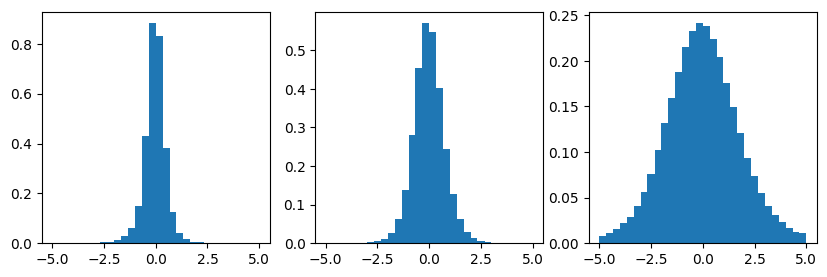

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))

states = intermediates['intermediates']['down_blocks_0']['__call__'][0][1]
def hist(w):
    plt.hist(w.flatten(),density=True,bins=30,range=[-5,5])

for i, w in enumerate(states):
    plt.subplot(1,len(states),i+1)
    hist(w)
    
print("Histogram of Some Hidden States")

In [49]:
# Reproduce "context" variable to make it clear... 
prompt_ids = tokenize([config.prompt], pipeline.tokenizer)
prompt_ids

array([[49406,   320,  7823,  3540,   530,   518,  3694,   539,   320,
         4167,   267, 12421,  3610, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])

In [50]:
c = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
c.shape

(1, 77, 1024)

Covariance Matrix of Language Tokens and Zoom-In of Non-Empty Words


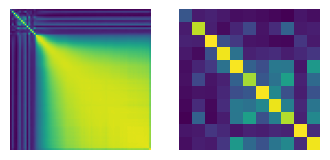

In [93]:
M = jnp.einsum('abc,dec->be',c,c)
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.imshow(M);plt.axis('off')
plt.subplot(122)
plt.imshow(M[:11,:11]);plt.axis('off')
print("Covariance Matrix of Language Tokens and Zoom-In of Non-Empty Words")

Covariant Matrices of Linear Embeddings in Some Layers. They are equivalent modulo SL(320) and we find some redundancies... Excercise: find more using intermediates!


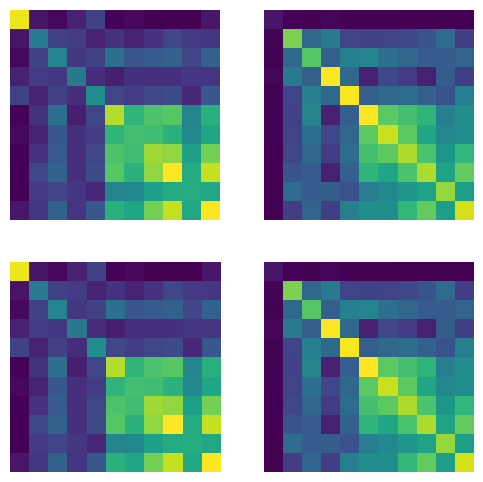

In [100]:
k1 = intermediates['intermediates']['down_blocks_0']['attentions_0']['transformer_blocks_0']['attn2']['to_k']['__call__'][0]
v1 = intermediates['intermediates']['down_blocks_0']['attentions_0']['transformer_blocks_0']['attn2']['to_v']['__call__'][0]
k2 = intermediates['intermediates']['down_blocks_0']['attentions_0']['transformer_blocks_0']['attn2']['to_k']['__call__'][0]
v2 = intermediates['intermediates']['down_blocks_0']['attentions_0']['transformer_blocks_0']['attn2']['to_v']['__call__'][0]
k1.shape,k2.shape,v1.shape,v2.shape
Mk1 = jnp.einsum('abc,dec->be',k1,k1).astype(jnp.float32)
Mv1 = jnp.einsum('abc,dec->be',v1,v1).astype(jnp.float32)
Mk2 = jnp.einsum('abc,dec->be',k2,k2).astype(jnp.float32)
Mv2 = jnp.einsum('abc,dec->be',v2,v2).astype(jnp.float32)
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.imshow(Mk1[:11,:11]);plt.axis('off')
plt.subplot(222)
plt.imshow(Mv1[:11,:11]);plt.axis('off')

plt.subplot(223)
plt.imshow(Mk2[:11,:11]);plt.axis('off')
plt.subplot(224)
plt.imshow(Mv2[:11,:11]);plt.axis('off')
print("Covariant Matrices of Linear Embeddings in Some Layers. They are equivalent modulo SL(320) and we find some redundancies... Excercise: find more using intermediates!")

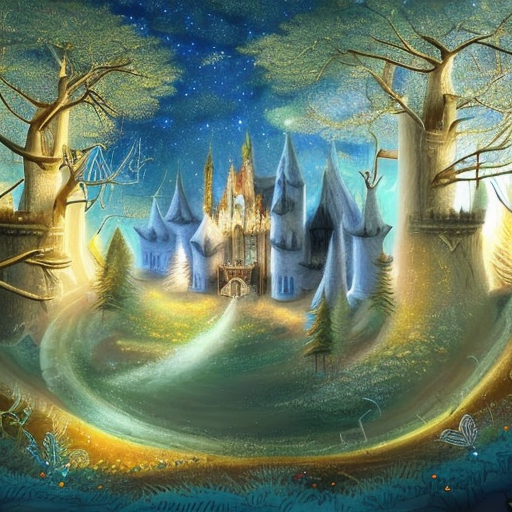

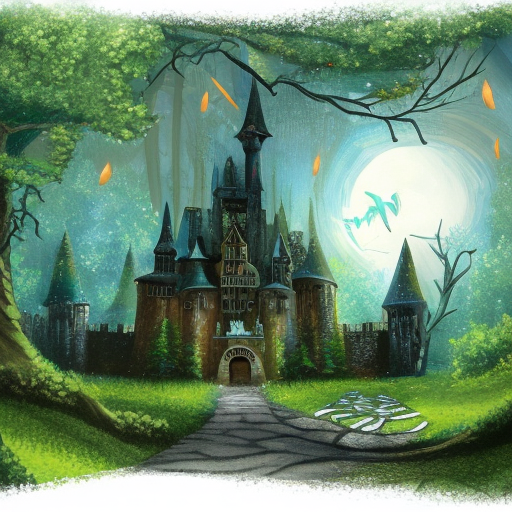

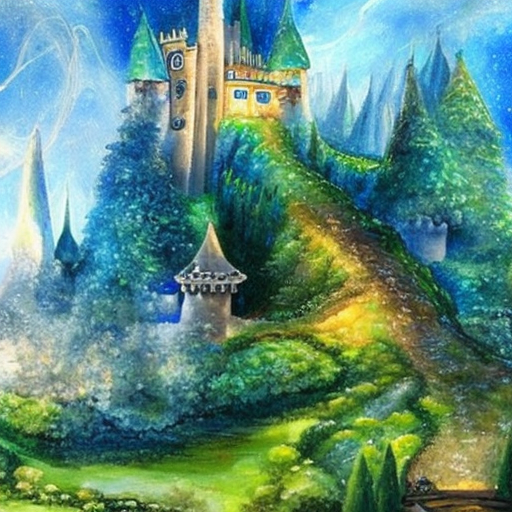

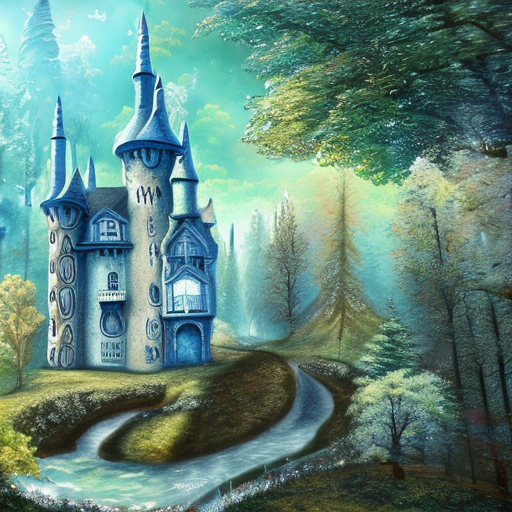

Lastly we show the generated images. Prompt: A magical castle in the middle of a forest, artistic drawing


In [99]:
[display(image) for image in images]
print("Lastly we show the generated images. Prompt:",config.prompt)